In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
# mpl.use('Cairo')  # for saving SVGs that Affinity Designer can parse
import matplotlib.pyplot as plt
import seaborn as sns
import dill

import candas as can
import gumbi as gmb
from candas.lims import Librarian, library
from candas.learn import ParameterSet
import pathlib as pl

code_pth = pl.Path.cwd()  # for running in Jupyter
# code_pth = pl.Path(__file__)  # for running in terminal
fig_pth = code_pth.parent
data_pth = fig_pth / 'data'
graph_pth = fig_pth / 'graphics'
graph_pth.mkdir(exist_ok=True)

gen_pth = fig_pth / 'generated'
gen_pth.mkdir(exist_ok=True)

plt.style.use(str(can.style.breve))

%config InlineBackend.figure_format = 'retina'

In [2]:
ps = ParameterSet.load(data_pth / "ADVI_ParameterSets_220528.pkl")
data = (
    ps.wide.query('Metric == "mean"')
    .astype({"BP": float})
    .groupby(["Target"])
    .mean()
    .reset_index()
)

ds = gmb.DataSet(
    data=data,
    outputs=["F0_lg", "r", "K", "m"],
    log_vars=["BP", "K", "m", "r"],
    logit_vars=["GC"],
)

/tmp/ipykernel_1018/3515649209.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = (ps.wide


# Average

In [6]:
recalculate = True

gp = gmb.GP(ds).fit(
    outputs="r",
    continuous_dims=["BP", "GC"],
)

In [7]:
predictions_dict = {}

/tmp/ipykernel_1018/3569153903.py:45: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  ax.scatter(gc, bp, c='0.5', cmap='flare_r', norm=rnorm, s=1)


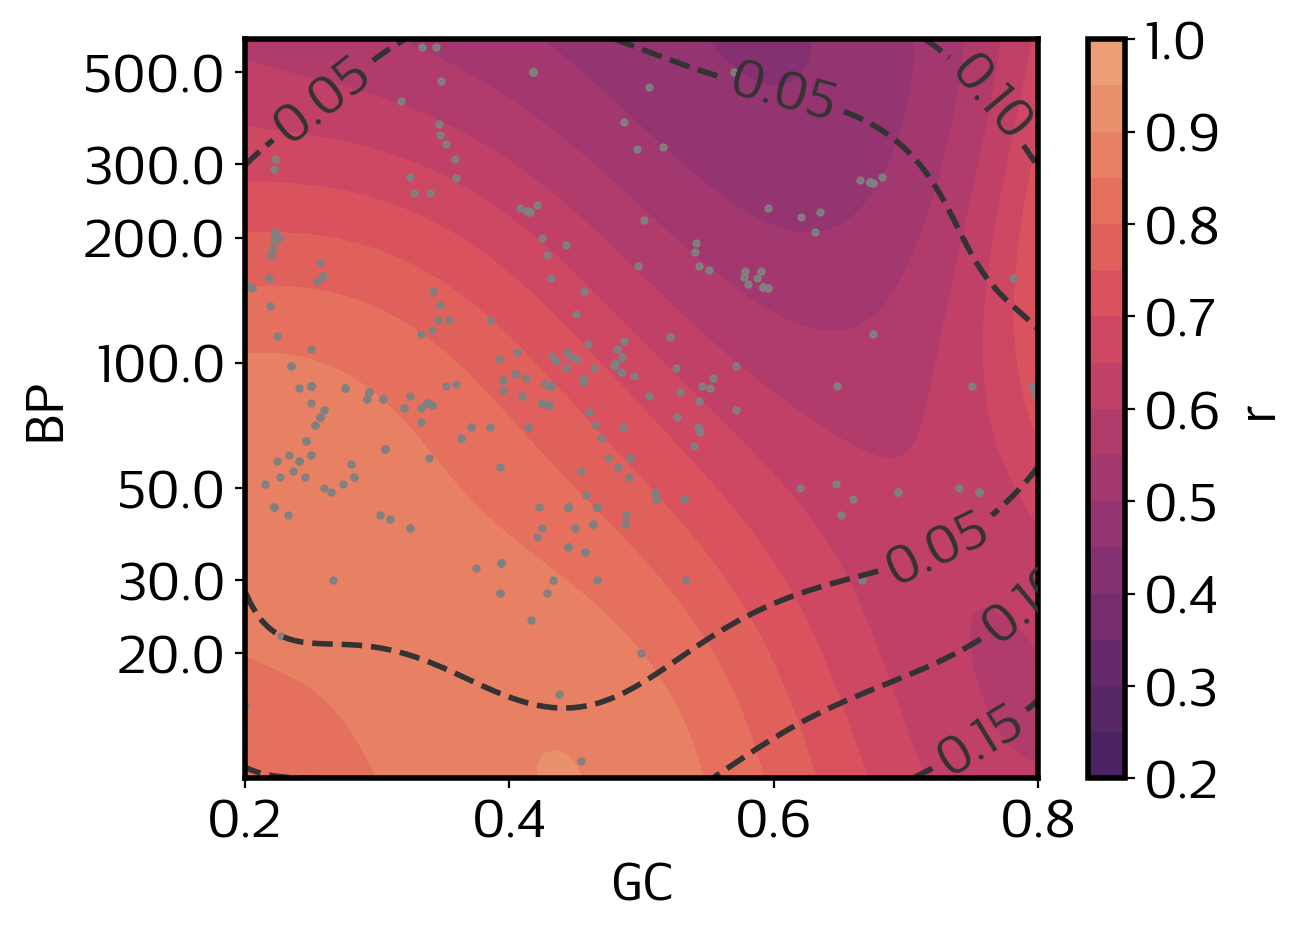

In [8]:
output = "r"
reporter = "HEX"

limits = gp.parray(GC=[0.2, 0.8], BP=[10, 600])
XY = gp.prepare_grid(limits=limits)
r = gp.predict_grid(
    output=output,
    with_noise=False,
    # categorical_levels={'Reporter': reporter}
)
BP, GC = XY["BP"], XY["GC"]

predictions_dict["r"] = r
predictions_dict["BP"] = BP
predictions_dict["GC"] = GC

pp = gmb.ParrayPlotter(
    x=GC,
    y=BP,
    z=r,
    #    x_scale='standardized',
    y_scale="standardized",
)

cmap = sns.color_palette("flare_r", as_cmap=True)
# rnorm = mpl.colors.Normalize()
# rnorm(r.μ)
rnorm = mpl.colors.Normalize(vmin=0.23, vmax=1.03)

cs = pp(plt.contourf, levels=np.arange(0.20, 1.05, 0.05), cmap="flare_r", norm=rnorm)
pp.colorbar(cs)

ax = plt.gca()

yticks = gp.parray(BP=[20, 30, 50, 100, 200, 300, 500])
ax.set_yticks(yticks["BP"].z.values())
ax.set_yticklabels(yticks.values())

gc = (
    ds.wide
    # .query('Reporter == @reporter')
    .GC
)
bp = (
    ds.wide.z
    # .query('Reporter == @reporter')
    .BP
)

ax.scatter(gc, bp, c="0.5", cmap="flare_r", norm=rnorm, s=1)

ax.set_xlim(limits["GC"].values())

cs = ax.contour(
    GC.values(),
    BP.z.values(),
    r.σ,
    levels=[0.05, 0.10, 0.15, 0.20, 0.25],
    colors="0.2",
    linestyles="--",
)
ax.clabel(cs)

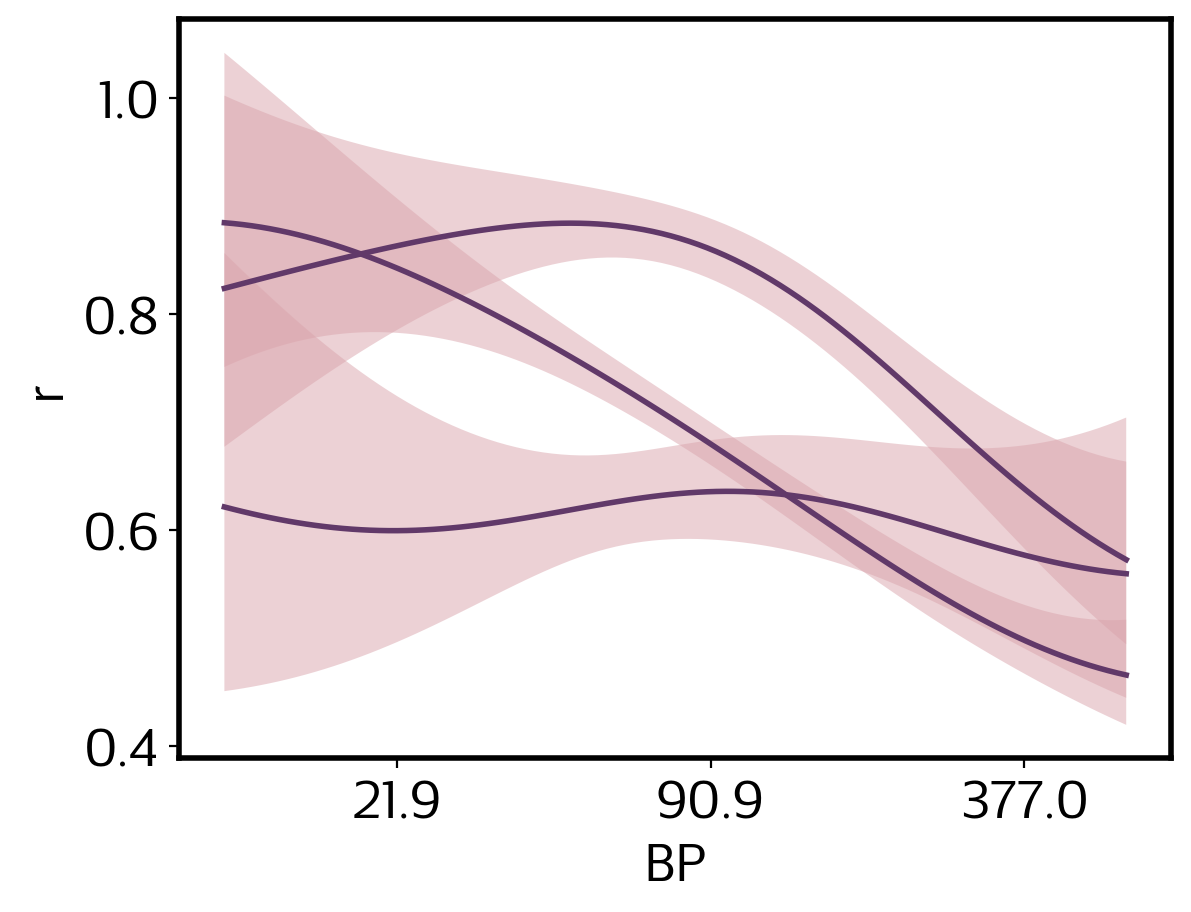

In [9]:
for gc in [0.25, 0.5, 0.75]:
    x_pa, y_upa = gp.get_conditional_prediction(GC=gc)
    gmb.ParrayPlotter(x_pa.z, y_upa).plot()
    predictions_dict[f"GC {gc:.2f}"] = [x_pa, y_upa]

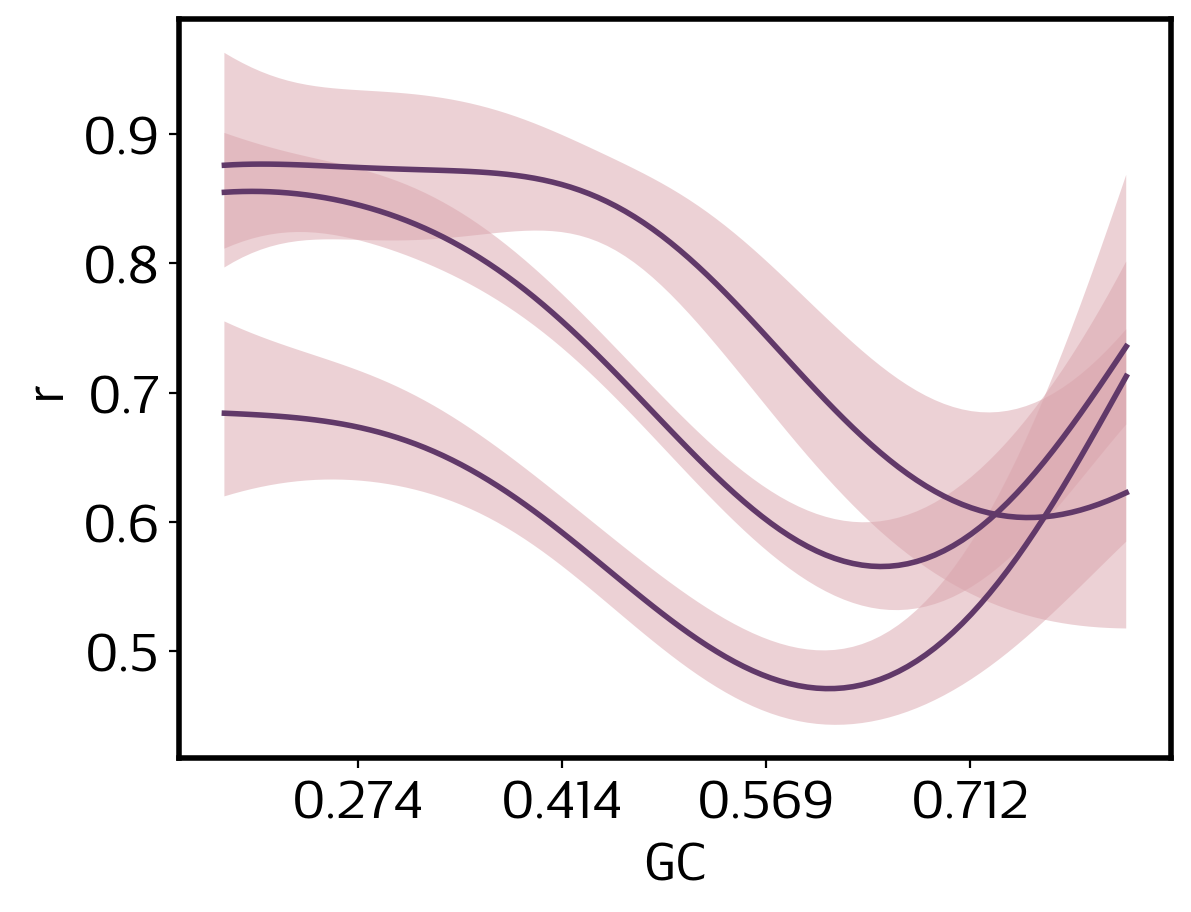

In [10]:
for bp in [30, 100, 300]:
    x_pa, y_upa = gp.get_conditional_prediction(BP=bp)
    gmb.ParrayPlotter(x_pa.z, y_upa).plot()
    predictions_dict[f"BP {bp}"] = [x_pa, y_upa]

In [12]:
## Dill needs to "warm up" for some reason??

for value in predictions_dict.values():
    dump = dill.dumps(value)
    loaded = dill.loads(dump)

In [13]:
with open(gen_pth / "Model_Avg_predictions.pkl", "wb") as f:
    dill.dump(predictions_dict, f)

with open(gen_pth / "Model_Avg_predictions.pkl", "rb") as f:
    loaded = dill.load(f)

loaded

{'r': r['μ', 'σ2']: [[(0.79991976, 0.01096032) (0.80206429, 0.01073843)
   (0.80423731, 0.01055582) ... (0.6039755 , 0.03167195)
   (0.60336343, 0.03228717) (0.60304709, 0.03290752)]
  [(0.80286086, 0.01032432) (0.80495371, 0.01009998)
   (0.80707019, 0.00991528) ... (0.60230586, 0.03068708)
   (0.60176455, 0.03131227) (0.60152054, 0.03194362)]
  [(0.8058341 , 0.00971878) (0.80787227, 0.00949206)
   (0.80992902, 0.00930529) ... (0.60076996, 0.02969312)
   (0.60030371, 0.03032739) (0.60013606, 0.03096888)]
  ...
  [(0.59701939, 0.00884485) (0.59555691, 0.00836657)
   (0.59412002, 0.00790777) ... (0.64400209, 0.01861926)
   (0.65459571, 0.01948506) (0.66520546, 0.02036491)]
  [(0.59264193, 0.00947412) (0.59110433, 0.00897495)
   (0.58959444, 0.00849491) ... (0.64170226, 0.01943251)
   (0.65212202, 0.02030433) (0.66255666, 0.02118942)]
  [(0.58849078, 0.01012861) (0.58687946, 0.00960891)
   (0.58529785, 0.00910794) ... (0.63952918, 0.02026191)
   (0.64977278, 0.02113808) (0.66002995, 0.02